
<div style="display: flex; align-items: center; justify-content: center; padding: 20px 0; text-align: center; height: 100vh; max-width: 1500px; margin: auto;">
    <img src="https://media.licdn.com/dms/image/v2/D4D3DAQFGx0XnuUvugA/image-scale_191_1128/image-scale_191_1128/0/1662458005755/nova_ims_information_management_school_cover?e=2147483647&v=beta&t=J3Q4LlZi36_4UAFhj2019QdtfXLn0kQwaX25jgaBhOQ" 
         alt="Logo" 
         style="width: 100%; max-width: 1500px; height: auto; max-height: 200px; object-fit: cover; object-position: center; border: 5px solid #A0C020; border-radius: 5px;">
</div>

<div style="text-align: center; padding: 20px 0;">
    <h5>This analysis is conducted as part of the <b><i>Text Mining</i></b> course, a component of the Master's program in Data Science and Advanced Analytics at the <b><u>Nova Information Management School</u></b>.</h5>
</div>
<!-- This notebook template was created by Catarina Gonçalves Nunes, 20230083 -->
<div style="text-align: center; color: #A0C020;">
    <h1><b>Predicting market behavior from tweets</b></h1>
</div>


<h3 style="text-align: center;"><u></b>Group 31</u></b></h3>

|     Student Name     |     Student ID     | 
|         ---          |           ---          |
|     David|         | 
|     Elcano           |              |
|     Jorge Cordeiro      |       20240594       |
|     Rui   |            |

# 1 - Importing libraries

In [2]:
import numpy as np
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob

# 2 -  Data loading and description

In [4]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

In [5]:
train_df.head()

,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0


In [6]:
test_df.head()

,id,text
0,0,ETF assets to surge tenfold in 10 years to $50...
1,1,Here’s What Hedge Funds Think Evolution Petrol...
2,2,$PVH - Phillips-Van Heusen Q3 2020 Earnings Pr...
3,3,China is in the process of waiving retaliatory...
4,4,"Highlight: “When growth is scarce, investors s..."


In [7]:
test_df.set_index('id', inplace=True)

In [8]:
test_df.head()

,text
id,
0,ETF assets to surge tenfold in 10 years to $50...
1,Here’s What Hedge Funds Think Evolution Petrol...
2,$PVH - Phillips-Van Heusen Q3 2020 Earnings Pr...
3,China is in the process of waiving retaliatory...
4,"Highlight: “When growth is scarce, investors s..."


# 3 - EDA

In [10]:
train_EDA = train_df.copy()
test_EDA = test_df.copy()

## 3.1 -  Data types

In [12]:
train_EDA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9543 entries, 0 to 9542
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    9543 non-null   object
 1   label   9543 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 149.2+ KB


We should convert the label column to int8

## 3.2 - Missing values

In [15]:
# Checking missing values - Code adapted from prev notebook
missing_values = train_EDA.isnull().sum().to_frame(name='Total')
missing_values['Percentage'] = (missing_values['Total'] / len(train_EDA) * 100).round(2).astype(str) + '%'
missing_values.sort_values(by='Total', ascending=False, inplace=True)
missing_values

,Total,Percentage
text,0,0.0%
label,0,0.0%


In [16]:
# Checking missing values - Code adapted from prev notebook
missing_values = test_EDA.isnull().sum().to_frame(name='Total')
missing_values['Percentage'] = (missing_values['Total'] / len(test_EDA) * 100).round(2).astype(str) + '%'
missing_values.sort_values(by='Total', ascending=False, inplace=True)
missing_values

,Total,Percentage
text,0,0.0%


## 3.3 - Class distribution


Class distribution in training set:
label
2    6178
1    1923
0    1442
Name: count, dtype: int64

Class distribution percentages:
label
2    64.738552
1    20.150896
0    15.110552
Name: count, dtype: float64


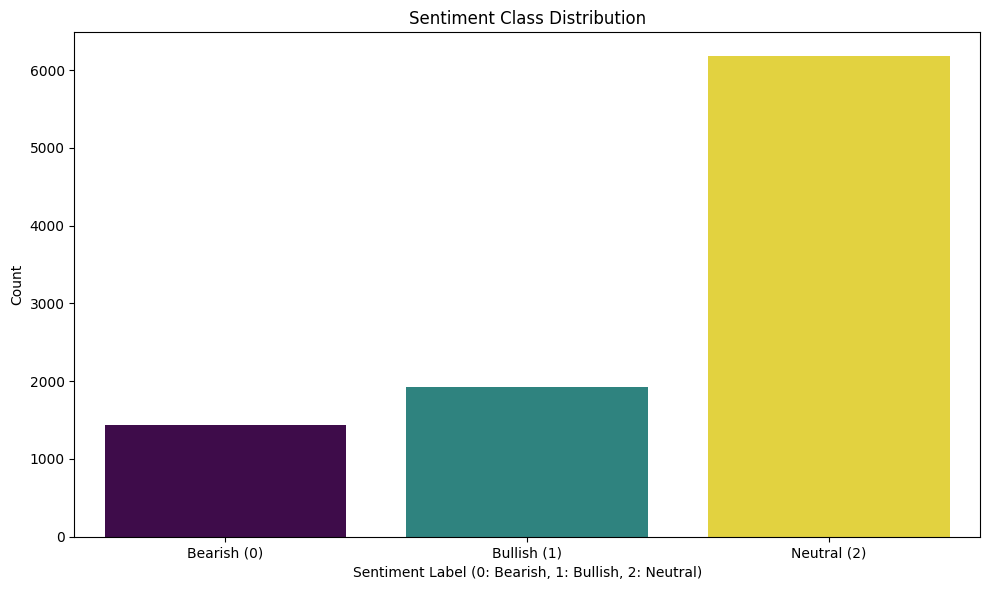

In [18]:
# Count and visualize class distribution
class_counts = train_EDA['label'].value_counts()
print("\nClass distribution in training set:")
print(class_counts)
print("\nClass distribution percentages:")
print(class_counts / len(train_EDA) * 100)

plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=train_EDA, hue='label', palette='viridis', legend=False)
plt.title('Sentiment Class Distribution')
plt.xlabel('Sentiment Label (0: Bearish, 1: Bullish, 2: Neutral)')
plt.ylabel('Count')
plt.xticks([0, 1, 2], ['Bearish (0)', 'Bullish (1)', 'Neutral (2)'])
plt.tight_layout()
plt.show()

## 3.4 - Character and text distribution

In [20]:
train_EDA['word_count']  = train_EDA['text'].apply(lambda x: len(str(x).split(" ")))
train_EDA[['text','word_count']].head()

,text,word_count
0,$BYND - JPMorgan reels in expectations on Beyo...,10
1,$CCL $RCL - Nomura points to bookings weakness...,14
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",14
3,$ESS: BTIG Research cuts to Neutral https://t....,7
4,$FNKO - Funko slides after Piper Jaffray PT cu...,10


In [21]:
train_EDA.word_count.describe()

count    9543.000000
mean       12.168081
std         4.651245
min         1.000000
25%         9.000000
50%        11.000000
75%        15.000000
max        31.000000
Name: word_count, dtype: float64

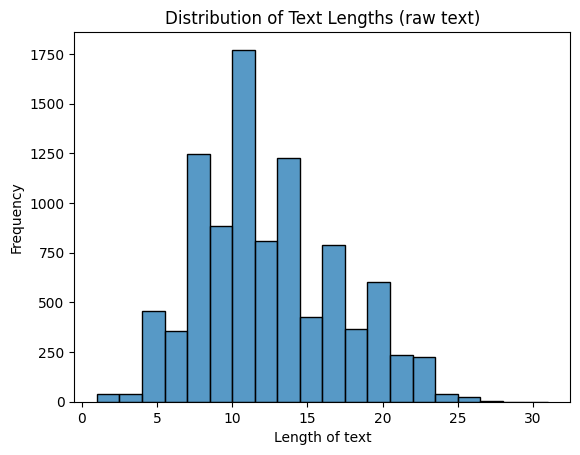

In [22]:
#Plot distribution of text length
sns.histplot(train_EDA['word_count'], bins=20)
plt.title("Distribution of Text Lengths (raw text)")
plt.xlabel("Length of text")
plt.ylabel("Frequency")
plt.show()

In [23]:
all_words = ' '.join(train_EDA['text']).split()
freq = pd.Series(all_words).value_counts()
freq.sort_values(ascending=False)[0:10]

to     2332
the    1820
of     1464
-      1390
in     1361
on     1136
for    1032
a       970
and     898
The     663
Name: count, dtype: int64

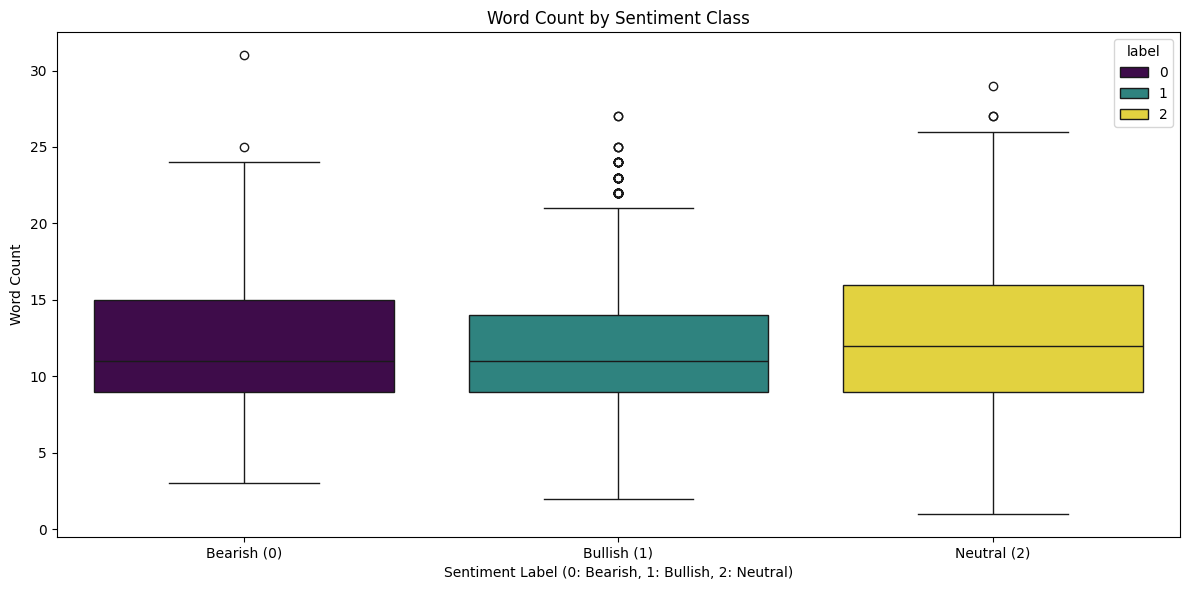

In [24]:
# Compare text length by sentiment class
plt.figure(figsize=(12, 6))
sns.boxplot(x='label', y='word_count', data=train_EDA,hue='label', palette='viridis')
plt.title('Word Count by Sentiment Class')
plt.xlabel('Sentiment Label (0: Bearish, 1: Bullish, 2: Neutral)')
plt.ylabel('Word Count')
plt.xticks([0, 1, 2], ['Bearish (0)', 'Bullish (1)', 'Neutral (2)'])
plt.tight_layout()
plt.show()

## 3.5 - Word Clouds

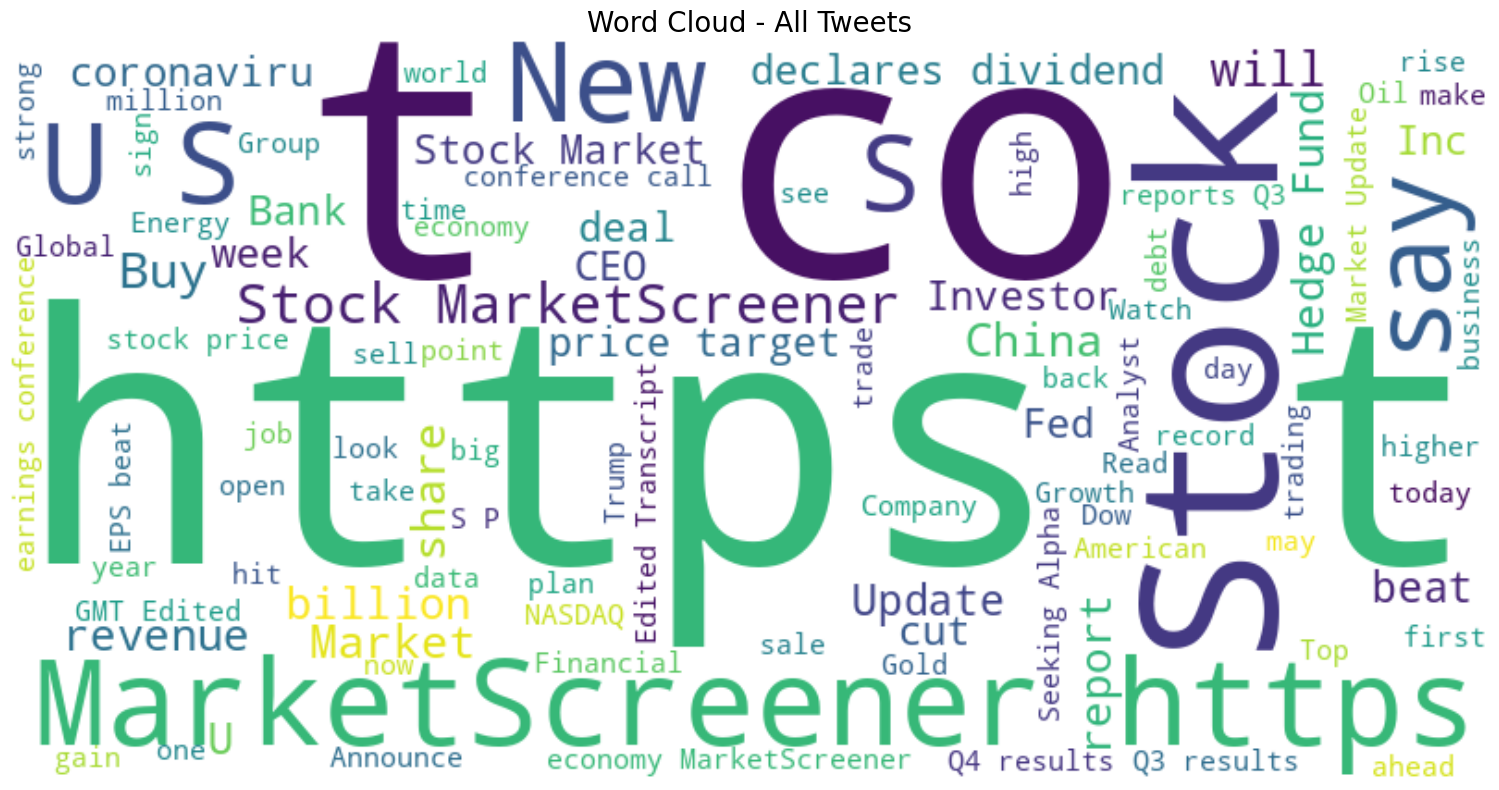

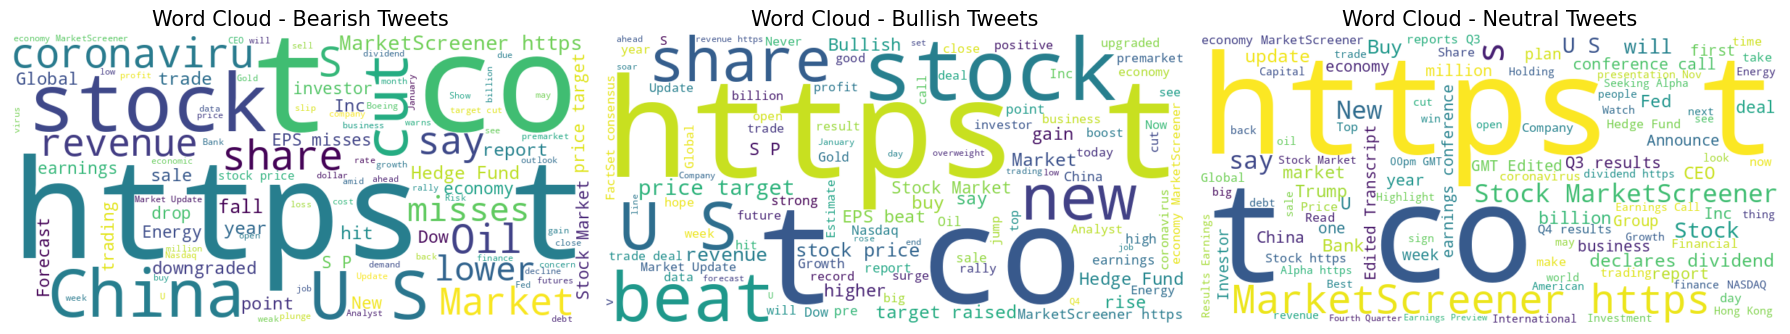

In [26]:


# Generate word cloud for all tweets
wordcloud = WordCloud(width=800, height=400, background_color='white', 
                     max_words=100, contour_width=3, contour_color='steelblue')
wordcloud.generate(' '.join(train_EDA['text']))

plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - All Tweets', fontsize=20)
plt.tight_layout()
plt.show()

# Generate word cloud for each sentiment class
plt.figure(figsize=(18, 6))
for i, (label, label_name) in enumerate([(0, 'Bearish'), (1, 'Bullish'), (2, 'Neutral')]):
    plt.subplot(1, 3, i+1)
    text = ' '.join(train_EDA[train_EDA['label'] == label]['text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white', 
                         max_words=100, contour_width=3, contour_color='steelblue')
    wordcloud.generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud - {label_name} Tweets', fontsize=15)

plt.tight_layout()
plt.show()

## 3.6 - Polarity scores

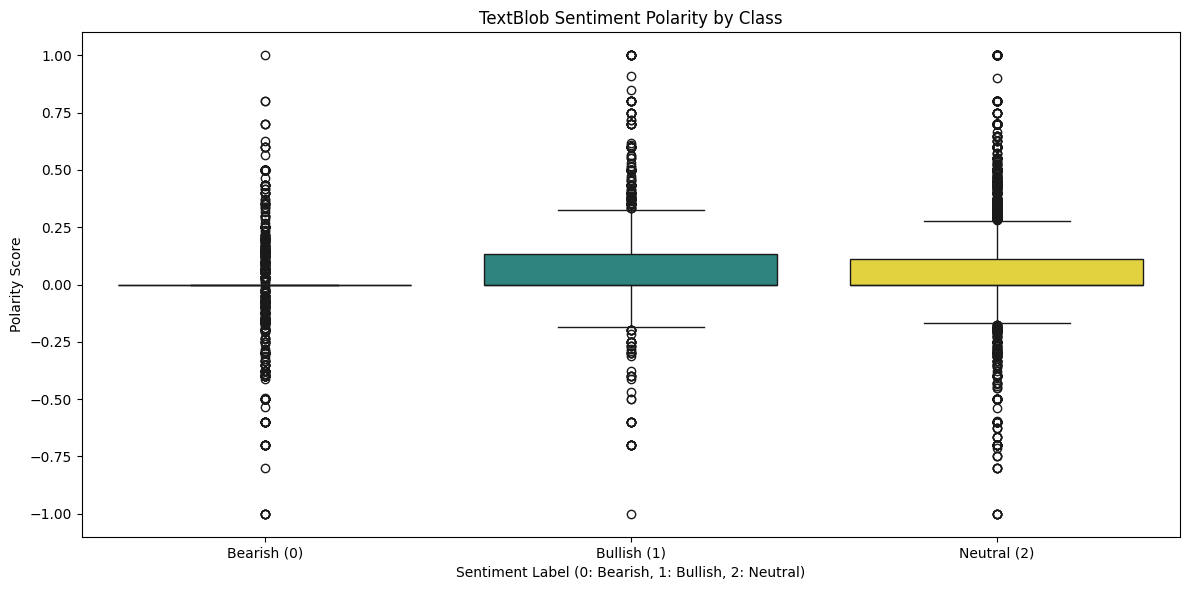

In [28]:
# Calculate polarity scores using TextBlob on original text
train_EDA['polarity'] = train_EDA['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
test_EDA['polarity'] = test_EDA['text'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Visualize polarity distribution by sentiment class
plt.figure(figsize=(12, 6))
sns.boxplot(x='label', y='polarity', data=train_EDA,hue='label', palette='viridis', legend=False)
plt.title('TextBlob Sentiment Polarity by Class')
plt.xlabel('Sentiment Label (0: Bearish, 1: Bullish, 2: Neutral)')
plt.ylabel('Polarity Score')
plt.xticks([0, 1, 2], ['Bearish (0)', 'Bullish (1)', 'Neutral (2)'])
plt.tight_layout()
plt.show()

## 🧠 Key Insights from Data Exploration

### 📊 Class Imbalance
- There is a significant imbalance among sentiment classes:
  - **Neutral (2)** is the most frequent with approximately **6,000 tweets**.
  - **Bullish (1)** follows with around **2,000 tweets**.
  - **Bearish (0)** is the least common, with roughly **1,500 tweecharacters**.

### ☁️ Word Clouds
- The term **"https"** is prevalent across all sentiment classes, suggesting **links are common** in tweets.
- Financial terms like **"MarketScreener"** appear frequently across all classes.

### 📈 Polarity Analysis (TextBlob)
- **Bearish tweets (0)** generally show **negative polarity**.
- **Bullish tweets (1)** tend to have **positive polarity**.
- **Neutral tweets (2)** have a more **even distribution**, but still lean slightly**Polarity scores**

✅ This alignment is **favorable for model generalization**.
